In [73]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [74]:
df = pd.read_csv('data/Video_Games.csv')

In [75]:
df = df.drop(columns=['Name'], axis=1)

In [76]:
df.head(5)

,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,PSP,2006.0,Sports,Activision,0.04,0.00,0.00,0.00,NaN,NaN,NaN,NaN,Sand Grain Studios,E
1,WiiU,2012.0,Platform,Nintendo,2.30,1.34,1.27,0.32,84.0,70.0,8.1,733.0,Nintendo,E
2,PS2,2005.0,Action,Vivendi Games,0.18,0.14,0.00,0.05,53.0,6.0,6.0,8.0,Eurocom Entertainment Software,E
3,GBA,2002.0,Simulation,Jorudan,0.00,0.00,0.35,0.01,NaN,NaN,NaN,NaN,NaN,NaN
4,PS2,2006.0,Racing,Sony Computer Entertainment,0.00,0.00,0.04,0.00,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11703 entries, 0 to 11702
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Platform         11703 non-null  object 
 1   Year_of_Release  11508 non-null  float64
 2   Genre            11702 non-null  object 
 3   Publisher        11665 non-null  object 
 4   NA_Sales         11703 non-null  float64
 5   EU_Sales         11703 non-null  float64
 6   JP_Sales         11703 non-null  float64
 7   Other_Sales      11703 non-null  float64
 8   Critic_Score     5676 non-null   float64
 9   Critic_Count     5676 non-null   float64
 10  User_Score       5319 non-null   float64
 11  User_Count       5319 non-null   float64
 12  Developer        7064 non-null   object 
 13  Rating           6957 non-null   object 
dtypes: float64(9), object(5)
memory usage: 1.3+ MB


In [78]:
def miss_val_percent(df):
    for col in df.columns:
        pct_missing = np.mean(df[col].isnull())
        print('{} - {}%'.format(col, round(pct_missing*100)))

In [79]:
miss_val_percent(df)

Platform - 0%
Year_of_Release - 2%
Genre - 0%
Publisher - 0%
NA_Sales - 0%
EU_Sales - 0%
JP_Sales - 0%
Other_Sales - 0%
Critic_Score - 51%
Critic_Count - 51%
User_Score - 55%
User_Count - 55%
Developer - 40%
Rating - 41%


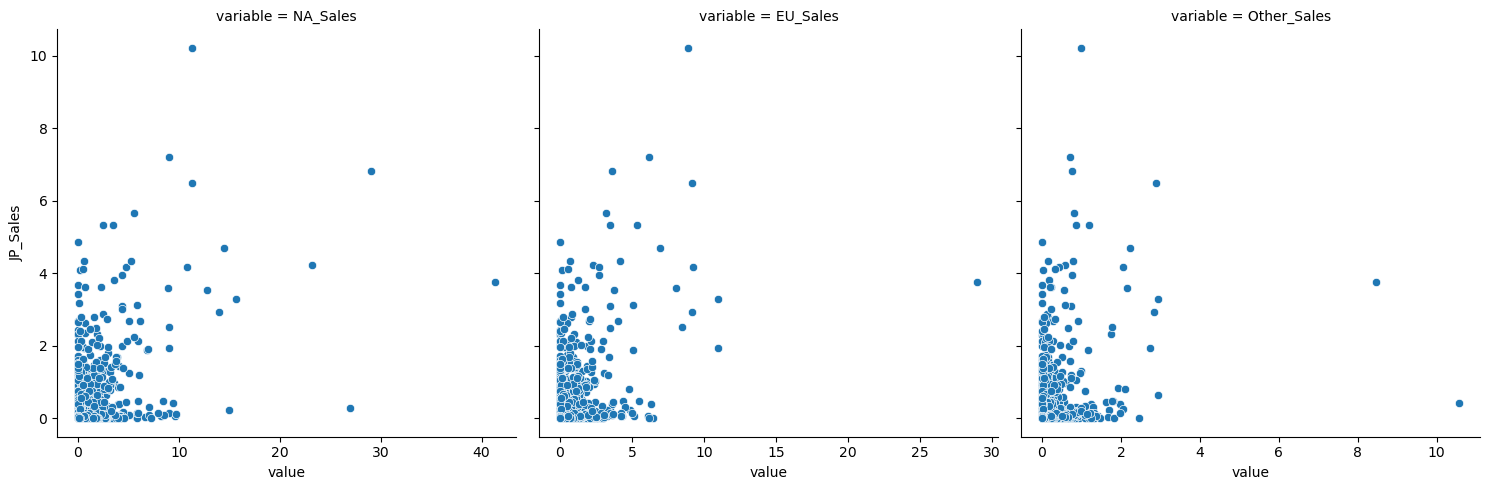

In [80]:
features = ["NA_Sales", "EU_Sales", "Other_Sales"]
sns.relplot(
    x="value", y="JP_Sales", col="variable", data=df.melt(id_vars="JP_Sales", value_vars=features), facet_kws=dict(sharex=False),
)

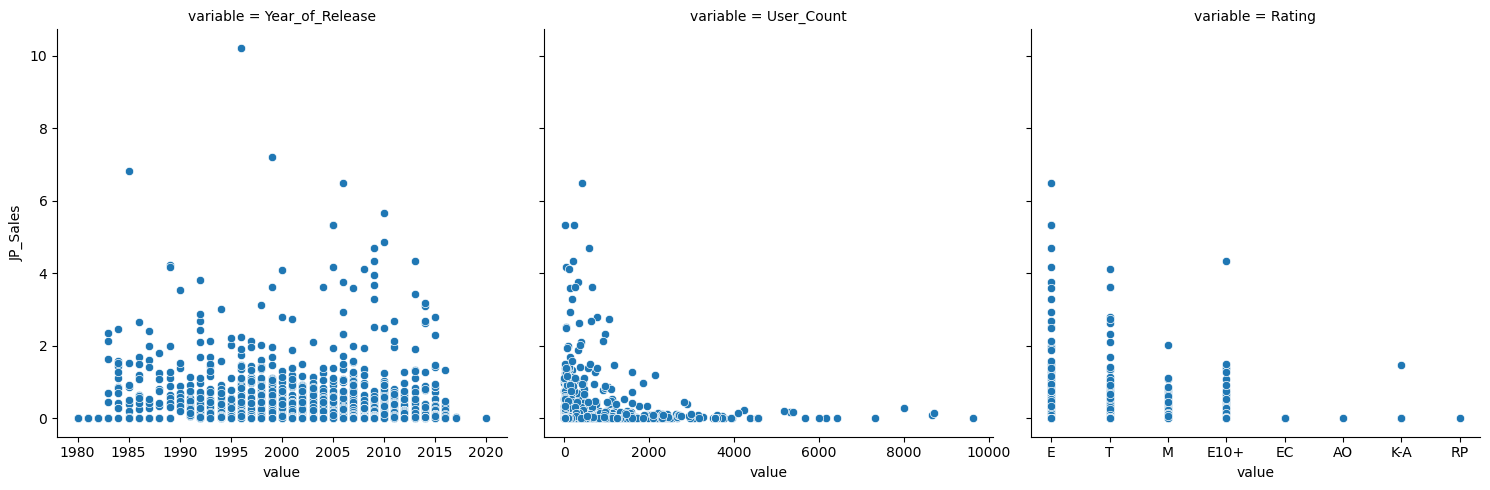

In [81]:
features = ["Year_of_Release", "User_Count", "Rating"]
sns.relplot(
    x="value", y="JP_Sales", col="variable", data=df.melt(id_vars="JP_Sales", value_vars=features), facet_kws=dict(sharex=False),
)

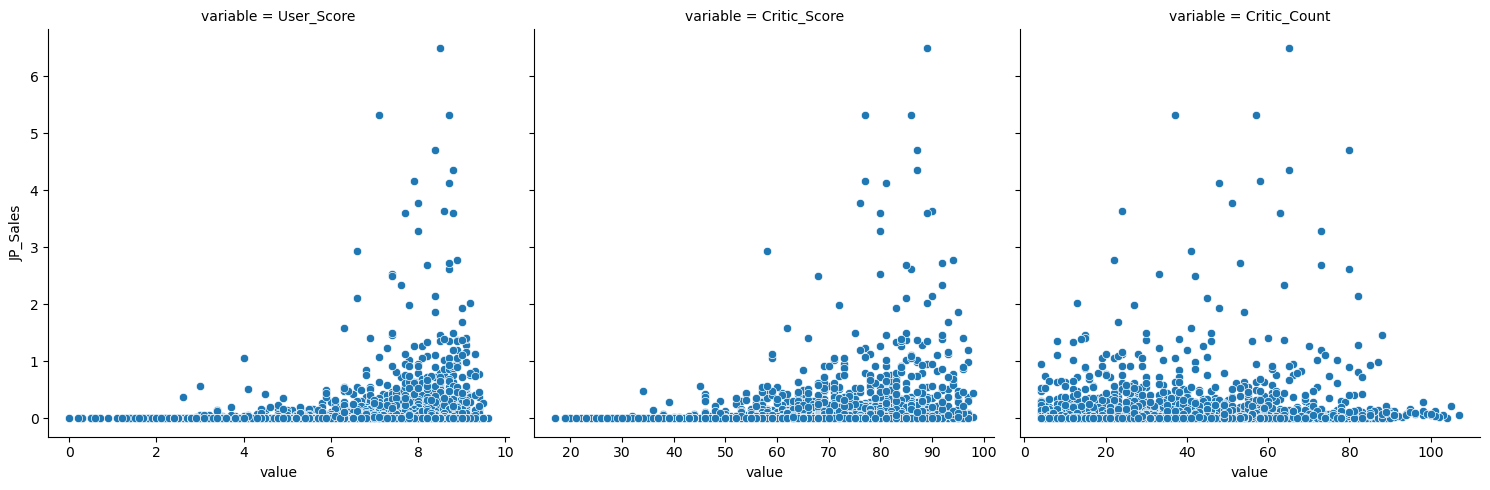

In [82]:
features = ["User_Score", "Critic_Score", "Critic_Count"]
sns.relplot(
    x="value", y="JP_Sales", col="variable", data=df.melt(id_vars="JP_Sales", value_vars=features), facet_kws=dict(sharex=False),
)

In [83]:
def impute(df):
    df['Year_of_Release'] = df['Year_of_Release'].fillna(2000)
    df['Critic_Score'] = df['Critic_Score'].fillna(df['Critic_Score'].median())
    df['Critic_Count'] = df['Critic_Count'].fillna(df['Critic_Count'].median())
    df['User_Score'] = df['User_Score'].fillna(df['User_Score'].median())
    df['User_Count'] = df['User_Count'].fillna(df['User_Count'].median())
    df['Developer'] = df['Developer'].fillna('Unknown')
    df['Genre'] = df['Genre'].fillna('Unknown')
    df['Publisher'] = df['Publisher'].fillna('Unknown')
    df['Rating'] = df['Rating'].fillna(method="backfill")
    return df

In [85]:
df = impute(df)

In [86]:
df.isnull().sum()

Platform           0
Year_of_Release    0
Genre              0
Publisher          0
NA_Sales           0
EU_Sales           0
JP_Sales           0
Other_Sales        0
Critic_Score       0
Critic_Count       0
User_Score         0
User_Count         0
Developer          0
Rating             0
dtype: int64

In [87]:
from sklearn.feature_selection import mutual_info_regression
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [90]:
X = df.copy()
y = X.pop('JP_Sales')

for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

mi_scores = make_mi_scores(X, y)

Publisher          0.364949
Developer          0.257466
Platform           0.200826
NA_Sales           0.178567
EU_Sales           0.142385
Year_of_Release    0.111076
Other_Sales        0.084908
Critic_Count       0.073532
Genre              0.064163
User_Count         0.059576
Critic_Score       0.055776
User_Score         0.035902
Rating             0.016207
Name: MI Scores, dtype: float64


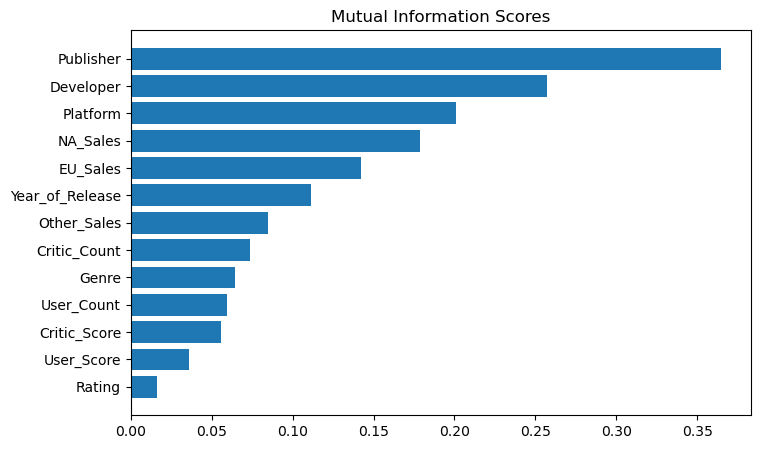

In [92]:
print(mi_scores.head(20))
# print(mi_scores.tail(20))  # uncomment to see bottom 20

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(20))

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11703 entries, 0 to 11702
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Platform         11703 non-null  object 
 1   Year_of_Release  11703 non-null  float64
 2   Genre            11703 non-null  object 
 3   Publisher        11703 non-null  object 
 4   NA_Sales         11703 non-null  float64
 5   EU_Sales         11703 non-null  float64
 6   JP_Sales         11703 non-null  float64
 7   Other_Sales      11703 non-null  float64
 8   Critic_Score     11703 non-null  float64
 9   Critic_Count     11703 non-null  float64
 10  User_Score       11703 non-null  float64
 11  User_Count       11703 non-null  float64
 12  Developer        11703 non-null  object 
 13  Rating           11703 non-null  object 
dtypes: float64(9), object(5)
memory usage: 1.3+ MB


In [99]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for col in X.select_dtypes(exclude=[np.number]).columns.values:
    X[col] = le.fit_transform(X[col])

In [109]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [110]:
import catboost as cb
cat = cb.CatBoostRegressor()
cat.fit(X_train, y_train, verbose=False)
y_pred = cat.predict(X_test)

In [111]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, y_pred)

0.060251259529967446

In [118]:
sub = pd.read_csv('data/Video_Games_Test.csv')
sub = sub.drop(columns=['Name'], axis=1)

In [119]:
sub = impute(sub)

for colname in sub.select_dtypes("object"):
    sub[colname], _ = sub[colname].factorize()

for col in sub.select_dtypes(exclude=[np.number]).columns.values:
    sub[col] = le.fit_transform(sub[col])

In [120]:
res = cat.predict(sub)

In [125]:
o = np.arange(1, len(res) + 1)

In [126]:
o

array([   1,    2,    3, ..., 5014, 5015, 5016])

In [ ]:
output = pd.DataFrame({'Id': o, 'Jp_Sales': res})
output.to_csv('submission.csv', index=False)